### Forecasting Time series Example 1.7
Forecasting solar activity is important for satellite drag, telecommunication outages and solar winds in connection with blackout of power plants. As an indicator of solar activity the sunspot number is used, among others. The Swiss astronomer Johann Rudolph Wolf introduced the sunspot number in 1848 and the number of sunspots is now known on a monthly basis back to the year 1749 (from 1749 to 1848 the data is questionable). The data set is built-in in **Python** and the following code produces the plot:

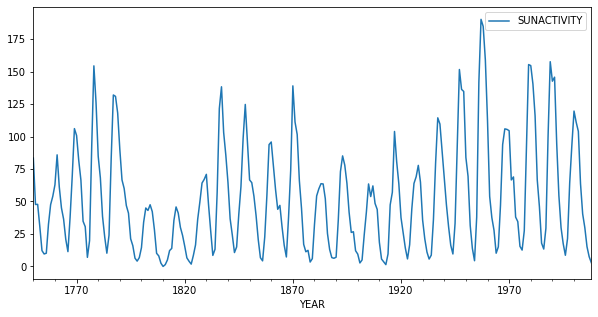

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Load data
dta = sm.datasets.sunspots.load_pandas().data

# Create pandas DateTimeIndex
dtindex = pd.DatetimeIndex(data=pd.to_datetime(dta["YEAR"], format="%Y"), 
                            freq='infer')
# Set as Index
dta.set_index(dtindex, inplace=True)
dta.drop("YEAR", axis=1, inplace=True)
# Select only data after 1750
dta = dta["1750":"2008"]

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
dta.plot(ax=ax)
plt.show()

It is important to note that the sunspot data is *not periodic*, i.e. the cycle duration is not constant. So the quasi periodic behaviour must not be mistaken for seasonality. The peaks and minima of the series are not known in advance. 

Eyeballing indicates that the underlying process is not stationary: There are clearly phases with different variances and means. We perform a Box-Cox square-root transform to stabilize the variance.

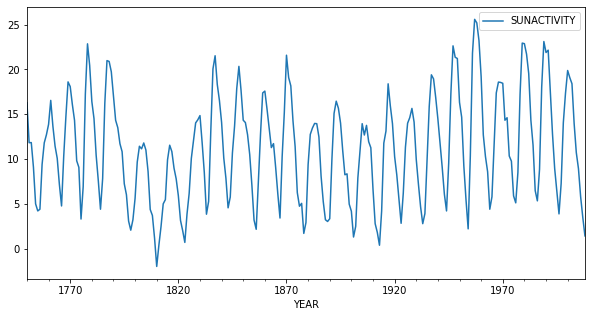

In [2]:
import numpy as np

# Box-Cox square root transformation
dta_sq = (np.sqrt(dta) - 1) * 2

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
dta_sq.plot(ax=ax)

plt.show()

The square-root transformed sequence is shown. The variance is visually stabilized and although there is still some trend visible, the series looks fairly stationary after the transformation. Next, we compute the autocorrelation and partial autocorrelation functions in order to clarify whether the autoregressive model is the right choice and in case to determine the proper model order.

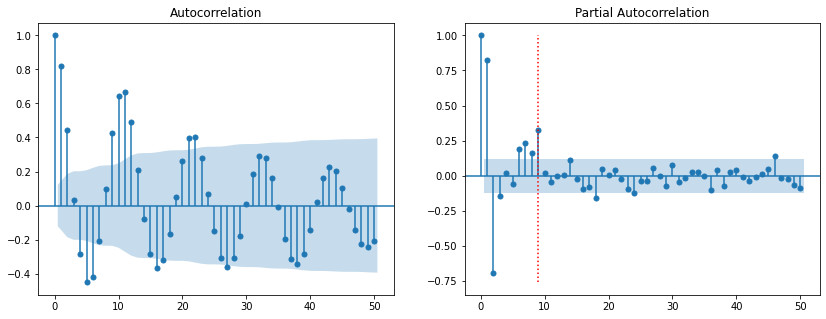

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# Plot
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1)
plot_acf(dta_sq, lags=50, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
plot_pacf(dta_sq, lags=50, ax=ax2)
ax2.plot([9, 9], [-0.76, 1], ':r')

plt.show()

The autocorrelation (left) and partial autocorrelation (right) are depicted. As it can be seen, the autocorrelation shows the typical behaviour of an autoregressive process: an oscillating pattern with an exponential decay. The partial autocorrelation shows that the direct dependency has a maximum lag of $9$ which we will use as our model parameter $p$ in the next section. The red dotted line marks this threshold.

### Forecasting Time series Example 1.8
We have a look at the sunspot number data set. We have transformed the data by a square-root and have concluded that it stems from an AR(9) model. We will now fit this model to the data

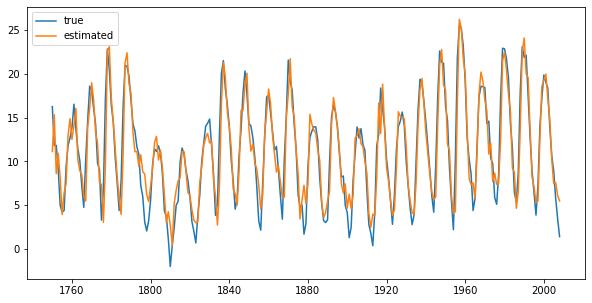

In [4]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(dta_sq, order=(9, 0, 0)).fit(method="yule_walker")

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dta_sq, label='true')
ax.plot(dta_sq["SUNACTIVITY"] - model.resid, label='estimated')
plt.legend()
plt.show()

In [5]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  259
Model:                 ARIMA(9, 0, 0)   Log Likelihood                -565.246
Date:                Tue, 05 Dec 2023   AIC                           1152.492
Time:                        16:01:16   BIC                           1191.617
Sample:                    01-01-1750   HQIC                          1168.222
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1370      1.211      9.200      0.000       8.764      13.510
ar.L1          1.1625      0.062     18.675      0.000       1.040       1.284
ar.L2         -0.4175      0.090     -4.658      0.0

The output above shows the $9$ estimated coefficients and the estimated variance of the white noise process. 

The figure shows the annually averaged time series and the output of the model. The fit seems to be reasonably accurate but we can further assess the result by examining residual plots. We choose a histogram and a qq-plot.

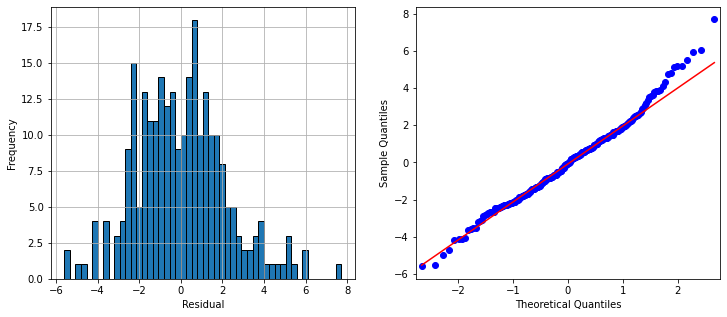

In [6]:
from statsmodels.graphics.api import qqplot

# Plot
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
model.resid.hist(edgecolor="black", bins=50, ax=ax1)
plt.xlabel("Residual")
plt.ylabel("Frequency")
ax2 = fig.add_subplot(1, 2, 2)
qqplot(model.resid, line="q", ax=ax2)

plt.show()

### Forecasting Time series Example 1.11
We again focus on the sunspot number data. We use the annual data from 1749 until 1989 as a training set and estimate an AR(9) model from that data. We then predict the sunspot number for 25 years into the future.  

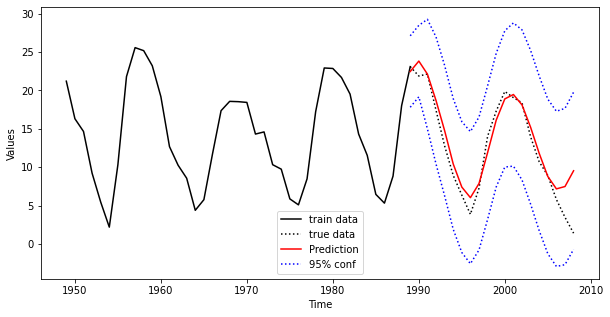

In [7]:
# Fit model on first 130 points
model = ARIMA(dta_sq["1749": "1989"], order=(9, 0, 0)).fit(method="yule_walker")

# Predict including confidence interval
pred = model.get_prediction(start="1989", end="2008").prediction_results
pred_cov = pred._forecasts_error_cov
pred = pred._forecasts[0]
pred_upper = pred + 1.96 * np.sqrt(pred_cov[0][0])
pred_lower = pred - 1.96 * np.sqrt(pred_cov[0][0])

# Plot
x = dta_sq.index.year
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dta_sq["1949": "1989"], '-k', label='train data')
ax.plot(dta_sq["1989": "2009"], ':k', label='true data')
ax.plot(dta_sq["1989": "2009"].index, pred, 'r', label='Prediction')
ax.plot(dta_sq["1989": "2009"].index, pred_upper, ':b', label='95% conf')
ax.plot(dta_sq["1989": "2009"].index, pred_lower, ':b')
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


The figure shows a window of the data set from 1950 until 2014. The training set is depicted by a black solid line and ranges up to 1989. The prediction is computed and plotted for the time period 1990 to 2012 together with the true data (black dotted) that has been discarded in the modelling step. As it can be seen, there is  good correspondence between true and estimated values for about 15 years. Then the prediction starts to diverge and the second minimum phase is not predicted correctly. 